### Enviroment Setup

#### Install Torch with CUDA

In [ ]:
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 -q

In [1]:
import torch
print(torch.cuda.is_available())  # Should return True if GPU is available

True


#### Download Dataset

In [ ]:
# !pip install gdown -q

This cell might take more than 1 minute to run

In [ ]:
# import os
# import gdown
# import zipfile

# # URL of the zip file on Google Drive
# url = 'https://drive.google.com/file/d/1OXoi4UeZy726ILuPM6Y57sr4eZhqrhq2/view?usp=sharing'

# # Function to download the zip file and extract it
# def download_and_extract_zip(url, extract_to='PlantVillage'):
#     # Generate the direct download URL for the file
#     file_id = url.split('/d/')[1].split('/')[0]
#     download_url = f'https://drive.google.com/uc?id={file_id}'

#     # Download the zip file
#     zip_file = 'PlantVillage.zip'
#     gdown.download(download_url, zip_file, quiet=False)

#     # Extract the zip file directly
#     with zipfile.ZipFile(zip_file, 'r') as zip_ref:
#         # Extract all the files directly into the 'extract_to' folder
#         zip_ref.extractall(extract_to)

#     # Remove the zip file after extraction
#     os.remove(zip_file)

# # Check if the 'PlantVillage' folder exists
# if not os.path.exists('PlantVillage') or not os.listdir('PlantVillage'):
#     download_and_extract_zip(url)

In [4]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

### Dataset Preprocessing

In [5]:
# Define transformations for your dataset
image_width = 32
transform = transforms.Compose([
    transforms.Resize((image_width, image_width)),  # Resize all images to 128x128
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Load train dataset
train_path = os.path.join('PlantVillage', 'train')
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)

# Load val dataset
val_path = os.path.join('PlantVillage', 'val')
val_dataset = datasets.ImageFolder(root=val_path, transform=transform)

# Split val dataset into val and test
test_split = 0.5  # Use 50% of the current val set as the test set
test_size = int(test_split * len(val_dataset))
val_size = len(val_dataset) - test_size

val_dataset, test_dataset = random_split(val_dataset, [val_size, test_size])

# Create DataLoaders for train, val, and test datasets
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Function to count class instances with a progress bar
def count_classes(dataset):
    class_counter = Counter()
    for _, label in tqdm(dataset, desc="Counting classes"):
        class_counter[label] += 1
    return class_counter

# Access class-to-index mapping
class_to_idx = train_dataset.class_to_idx
print("Class to index mapping:", class_to_idx)

def count_classes_in_folders(dataset_path):
    """
    Count the number of items in each class folder in the dataset.
    """
    class_counts = {}
    for class_name in os.listdir(dataset_path):
        class_folder = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_folder):  # Ensure it's a directory
            class_counts[class_name] = len(os.listdir(class_folder))
    return class_counts

# Count classes
train_class_counts = count_classes_in_folders(train_path)

# Create a DataFrame from the train_class_counts dictionary
class_df = pd.DataFrame(list(train_class_counts.items()), columns=["Class", "Count"])

# Sort the DataFrame by 'Count' in ascending order
class_df_sorted = class_df.sort_values(by="Count", ascending=True).reset_index(drop=True)

# Print the sorted DataFrame
print(class_df_sorted)

Class to index mapping: {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___L

In [ ]:
# import torch.optim as optim

# # Model, loss function, optimizer
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available
# num_classes = len(train_dataset.classes)
# model = SimpleCNN(num_classes=num_classes, image_width=image_width).to(device)  # Move model to device
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Set maximum number of epochs and patience for early stopping
# max_epochs = 40
# patience = 5  # Number of epochs with no improvement after which training will stop
# best_val_loss = float('inf')  # Initialize best validation loss as infinity
# epochs_without_improvement = 0

# # Training loop
# for epoch in range(max_epochs):
#     model.train()
#     running_loss = 0.0
#     train_loader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs}", unit="batch")  # Add tqdm to training loop
    
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)  # Move data to device
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#         train_loader.set_postfix(loss=loss.item())  # Update tqdm progress bar with current loss
    
#     print(f"Epoch {epoch+1}, Average Loss: {(running_loss / len(train_loader)):.4f}")

#     # Evaluate on the validation dataset
#     model.eval()
#     correct = 0
#     total = 0
#     val_loss = 0.0
#     with torch.no_grad():  # Disable gradient computation during evaluation
#         for images, labels in val_loader:  # Assuming val_loader is the DataLoader for the test/validation set
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item()
            
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
    
#     avg_val_loss = val_loss / len(val_loader)
#     accuracy = 100 * correct / total
#     print(f"Validation Accuracy: {accuracy:.2f}%")
#     print(f"Validation Loss: {avg_val_loss:.4f}")
    
#     # Check for early stopping
#     if avg_val_loss < best_val_loss:
#         best_val_loss = avg_val_loss
#         epochs_without_improvement = 0  # Reset counter
#     else:
#         epochs_without_improvement += 1
#         if epochs_without_improvement >= patience:
#             print(f"Early stopping triggered after {epoch+1} epochs.")
#             break  # Stop training early if no improvement

#     # Check if we have reached the maximum number of epochs
#     if epoch + 1 == max_epochs:
#         print("Maximum number of epochs reached.")
#         break

### Training function

In [6]:
import torch.optim as optim

def train_model(model, criterion, optimizer, num_classes, train_loader, epoch=50):
    # Model, loss function, optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available
    # num_classes = len(train_dataset.classes)
    # model = SimpleCNN(num_classes=num_classes, image_width=image_width).to(device)  # Move model to device
    # criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Set maximum number of epochs and patience for early stopping
    max_epochs = epoch
    patience = 5  # Number of epochs with no improvement after which training will stop
    best_val_loss = float('inf')  # Initialize best validation loss as infinity
    epochs_without_improvement = 0

    # Training loop
    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0
        train_loader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs}", unit="batch")  # Add tqdm to training loop
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to device
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            train_loader.set_postfix(loss=loss.item())  # Update tqdm progress bar with current loss
        
        print(f"Epoch {epoch+1}, Average Loss: {(running_loss / len(train_loader)):.4f}")

        # Evaluate on the validation dataset
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad():  # Disable gradient computation during evaluation
            for images, labels in val_loader:  # Assuming val_loader is the DataLoader for the test/validation set
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        avg_val_loss = val_loss / len(val_loader)
        accuracy = 100 * correct / total
        print(f"Validation Accuracy: {accuracy:.2f}%")
        print(f"Validation Loss: {avg_val_loss:.4f}")
        
        # Check for early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0  # Reset counter
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break  # Stop training early if no improvement

        # Check if we have reached the maximum number of epochs
        if epoch + 1 == max_epochs:
            print("Maximum number of epochs reached.")
            break

In [ ]:
# from sklearn.metrics import f1_score

# # Evaluate on the test dataset with tqdm
# model.eval()
# correct = 0
# total = 0
# all_labels = []  # To store true labels
# all_preds = []   # To store predicted labels
# test_loader = tqdm(test_loader, desc="Testing", unit="batch")  # Add tqdm for the test loop

# with torch.no_grad():  # Disable gradient computation during evaluation
#     for images, labels in test_loader:  # Loop through test dataset
#         images, labels = images.to(device), labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
        
#         all_labels.extend(labels.cpu().numpy())  # Append true labels
#         all_preds.extend(predicted.cpu().numpy())  # Append predicted labels
        
#         # Update tqdm bar with current accuracy
#         test_loader.set_postfix(accuracy=(100 * correct / total))  

# # Compute test accuracy
# test_accuracy = 100 * correct / total

# # Compute F1 score for the whole dataset
# f1 = f1_score(all_labels, all_preds, average='weighted')  # You can also use 'macro' or 'micro' as needed

# print(f"\nTest Accuracy: {test_accuracy:.2f}%")
# print(f"Test F1 Score (Weighted): {f1:.4f}")

### Testing function

In [7]:
from sklearn.metrics import f1_score

def test_model(model, test_loader):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available

    # Evaluate on the test dataset with tqdm
    model.eval()
    correct = 0
    total = 0
    all_labels = []  # To store true labels
    all_preds = []   # To store predicted labels
    test_loader = tqdm(test_loader, desc="Testing", unit="batch")  # Add tqdm for the test loop

    with torch.no_grad():  # Disable gradient computation during evaluation
        for images, labels in test_loader:  # Loop through test dataset
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())  # Append true labels
            all_preds.extend(predicted.cpu().numpy())  # Append predicted labels
            
            # Update tqdm bar with current accuracy
            test_loader.set_postfix(accuracy=(100 * correct / total))  

    # Compute test accuracy
    test_accuracy = 100 * correct / total

    # Compute F1 score for the whole dataset
    f1 = f1_score(all_labels, all_preds, average='weighted')  # You can also use 'macro' or 'micro' as needed

    print(f"\nTest Accuracy: {test_accuracy:.2f}%")
    print(f"Test F1 Score (Weighted): {f1:.4f}")

### Evaluation function

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

class_names = train_dataset.classes

def evaluate_model(model, val_loader, class_names):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    metrics_report = classification_report(all_labels, all_preds, target_names=class_names)
    print(metrics_report)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.show()

    return cm, metrics_report

### Simple CNN Model Training and Testing

#### Model definition

In [27]:
import torch
import torch.nn as nn


class SimpleCNN(nn.Module):
    def __init__(self, num_classes, image_width):
        super(SimpleCNN, self).__init__()  # Call the parent class constructor
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # nn.Conv2d(35, 60, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm2d(60),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Dropout(0.20)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * (image_width//4)**2, 512),
            nn.ReLU(),
            nn.Dropout(0.45),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

Another Model

In [9]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes, image_width, num_layers=2, first_layer_filters=16):
        super(SimpleCNN, self).__init__()

        self.num_layers = num_layers
        self.first_layer_filters = first_layer_filters

        layers = []
        in_channels = 3
        out_channels = first_layer_filters

        for i in range(num_layers):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))  # Halves spatial dimensions

            in_channels = out_channels
            out_channels *= 2  # Double the number of filters for each subsequent layer

        layers.append(nn.Dropout(0.2))

        self.features = nn.Sequential(*layers)

        # Calculate the output size after the convolutional layers
        final_width = image_width // (2 ** num_layers)
        self.classifier = nn.Sequential(
            nn.Linear(in_channels * (final_width ** 2), 512),
            nn.ReLU(),
            nn.Dropout(0.45),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

#### Training

In [29]:
num_classes = len(train_dataset.classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available
model = SimpleCNN(num_classes=num_classes, image_width=image_width, num_layers=2, first_layer_filters=16).to(device)  # Move model to device

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, criterion, optimizer, num_classes, train_loader, epoch=40)

Epoch 1/40:   0%|          | 0/1358 [00:00<?, ?batch/s]

Epoch 1/40: 100%|██████████| 1358/1358 [00:11<00:00, 117.72batch/s, loss=0.784]

Epoch 1, Average Loss: 1.2777


Validation Accuracy: 79.76%
Validation Loss: 0.6596


Epoch 2/40: 100%|██████████| 1358/1358 [00:07<00:00, 181.47batch/s, loss=0.187]

Epoch 2, Average Loss: 0.5985


Validation Accuracy: 87.11%
Validation Loss: 0.4098


Epoch 3/40: 100%|██████████| 1358/1358 [00:08<00:00, 166.21batch/s, loss=0.29]  


Epoch 3, Average Loss: 0.4203
Validation Accuracy: 90.43%
Validation Loss: 0.2879


Epoch 4/40: 100%|██████████| 1358/1358 [00:08<00:00, 166.59batch/s, loss=0.177] 

Epoch 4, Average Loss: 0.3431


Validation Accuracy: 91.18%
Validation Loss: 0.2659


Epoch 5/40: 100%|██████████| 1358/1358 [00:08<00:00, 166.98batch/s, loss=0.124] 

Epoch 5, Average Loss: 0.2867


Validation Accuracy: 92.69%
Validation Loss: 0.2225


Epoch 6/40: 100%|██████████| 1358/1358 [00:08<00:00, 168.49batch/s, loss=0.169] 


Epoch 6, Average Loss: 0.2397
Validation Accuracy: 93.52%
Validation Loss: 0.2091


Epoch 7/40: 100%|██████████| 1358/1358 [00:07<00:00, 187.59batch/s, loss=0.296] 


Epoch 7, Average Loss: 0.2165
Validation Accuracy: 94.26%
Validation Loss: 0.1683


Epoch 8/40: 100%|██████████| 1358/1358 [00:08<00:00, 167.01batch/s, loss=0.413] 

Epoch 8, Average Loss: 0.1960


Validation Accuracy: 93.65%
Validation Loss: 0.1992


Epoch 9/40: 100%|██████████| 1358/1358 [00:08<00:00, 167.44batch/s, loss=0.444]  

Epoch 9, Average Loss: 0.1705


Validation Accuracy: 94.51%
Validation Loss: 0.1651


Epoch 10/40: 100%|██████████| 1358/1358 [00:08<00:00, 168.50batch/s, loss=0.0514] 

Epoch 10, Average Loss: 0.1577


Validation Accuracy: 94.72%
Validation Loss: 0.1700


Epoch 11/40: 100%|██████████| 1358/1358 [00:08<00:00, 165.05batch/s, loss=0.0454] 

Epoch 11, Average Loss: 0.1451


Validation Accuracy: 94.75%
Validation Loss: 0.1652


Epoch 12/40: 100%|██████████| 1358/1358 [00:07<00:00, 190.10batch/s, loss=0.147]  

Epoch 12, Average Loss: 0.1348


Validation Accuracy: 94.81%
Validation Loss: 0.1788


Epoch 13/40: 100%|██████████| 1358/1358 [00:08<00:00, 167.33batch/s, loss=0.0608] 

Epoch 13, Average Loss: 0.1313


Validation Accuracy: 94.33%
Validation Loss: 0.1798


Epoch 14/40: 100%|██████████| 1358/1358 [00:08<00:00, 165.51batch/s, loss=0.119]  

Epoch 14, Average Loss: 0.1196


Validation Accuracy: 95.36%
Validation Loss: 0.1532


Epoch 15/40: 100%|██████████| 1358/1358 [00:08<00:00, 167.09batch/s, loss=0.0661] 


Epoch 15, Average Loss: 0.1184
Validation Accuracy: 94.33%
Validation Loss: 0.2019


Epoch 16/40: 100%|██████████| 1358/1358 [00:07<00:00, 181.36batch/s, loss=0.0583] 

Epoch 16, Average Loss: 0.1160


Validation Accuracy: 95.86%
Validation Loss: 0.1371


Epoch 17/40: 100%|██████████| 1358/1358 [00:08<00:00, 168.60batch/s, loss=0.0795] 

Epoch 17, Average Loss: 0.1096


Validation Accuracy: 95.47%
Validation Loss: 0.1540


Epoch 18/40: 100%|██████████| 1358/1358 [00:08<00:00, 166.78batch/s, loss=0.517]  

Epoch 18, Average Loss: 0.1049


Validation Accuracy: 95.30%
Validation Loss: 0.1681


Epoch 19/40: 100%|██████████| 1358/1358 [00:07<00:00, 180.39batch/s, loss=0.0141]  

Epoch 19, Average Loss: 0.0975


Validation Accuracy: 96.00%
Validation Loss: 0.1541


Epoch 20/40: 100%|██████████| 1358/1358 [00:08<00:00, 167.11batch/s, loss=0.0579]  

Epoch 20, Average Loss: 0.1006


Validation Accuracy: 95.84%
Validation Loss: 0.1473


Epoch 21/40: 100%|██████████| 1358/1358 [00:08<00:00, 165.82batch/s, loss=0.263]   

Epoch 21, Average Loss: 0.0931


Validation Accuracy: 95.99%
Validation Loss: 0.1415
Early stopping triggered after 21 epochs.


#### Testing

In [30]:
test_model(model, test_loader)

Testing: 100%|██████████| 170/170 [00:01<00:00, 133.89batch/s, accuracy=96.3]



Test Accuracy: 96.30%
Test F1 Score (Weighted): 0.9631


#### Evaluation

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.85      0.70      0.76        56
                                 Apple___Black_rot       0.91      0.98      0.95        65
                          Apple___Cedar_apple_rust       0.88      0.71      0.79        21
                                   Apple___healthy       0.92      0.87      0.89       164
                               Blueberry___healthy       0.88      0.99      0.94       160
          Cherry_(including_sour)___Powdery_mildew       0.92      0.99      0.95       111
                 Cherry_(including_sour)___healthy       0.96      0.93      0.94        72
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.75      0.95      0.84        41
                       Corn_(maize)___Common_rust_       1.00      0.95      0.98       108
               Corn_(maize)___Northern_Leaf_Blight       0.94      0.83      0.

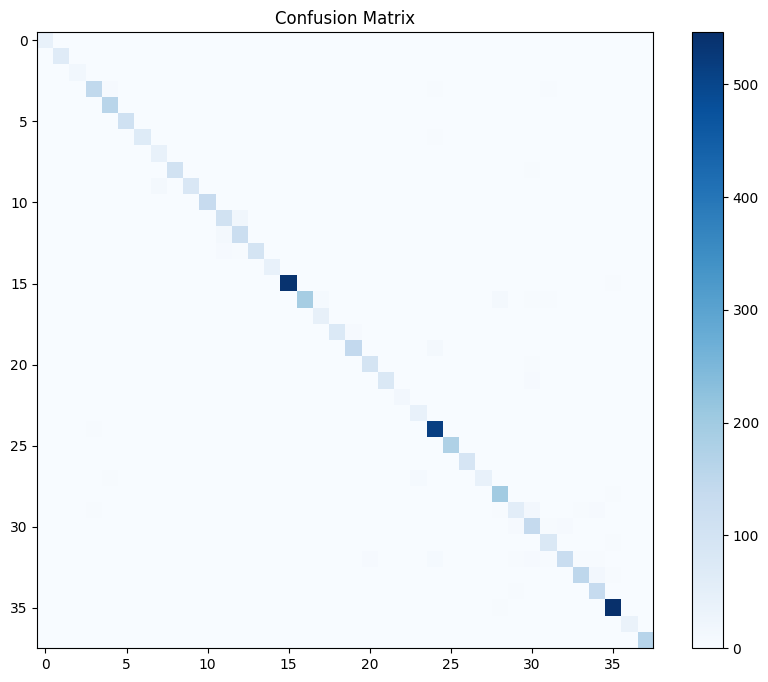

(array([[ 39,   2,   0, ...,   0,   0,   0],
        [  0,  64,   0, ...,   0,   0,   0],
        [  0,   0,  15, ...,   1,   0,   0],
        ...,
        [  0,   0,   0, ..., 546,   0,   0],
        [  0,   0,   0, ...,   0,  36,   0],
        [  0,   0,   0, ...,   0,   0, 160]]),
 '                                                    precision    recall  f1-score   support\n\n                                Apple___Apple_scab       0.85      0.70      0.76        56\n                                 Apple___Black_rot       0.91      0.98      0.95        65\n                          Apple___Cedar_apple_rust       0.88      0.71      0.79        21\n                                   Apple___healthy       0.92      0.87      0.89       164\n                               Blueberry___healthy       0.88      0.99      0.94       160\n          Cherry_(including_sour)___Powdery_mildew       0.92      0.99      0.95       111\n                 Cherry_(including_sour)___healthy       0.9

In [41]:
# Retrieve model from file 

num_classes = len(train_dataset.classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available
model = SimpleCNN(num_classes=num_classes, image_width=256, num_layers=2, first_layer_filters=16).to(device)  # Move model to device

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.load_state_dict(torch.load('plant_disease_model_256.pth'))
model = model.to(device)

evaluate_model(model, test_loader, class_names)

#### Model saving

In [32]:
# Save model to file
torch.save(model.state_dict(), 'plant_disease_model_32_3layer_32initial.pth')

#### Model Loading from file

In [10]:
# Retrieve model from file 

num_classes = len(train_dataset.classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available
model = SimpleCNN(num_classes=num_classes, image_width=image_width).to(device)  # Move model to device

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.load_state_dict(torch.load('plant_disease_model.pth'))
model = model.to(device)

#### Predict single image from external JPG image

In [49]:
from PIL import Image
import torch
import torchvision.transforms as transforms

# Load the trained model
model.load_state_dict(torch.load('plant_disease_model_256.pth'))
model.eval()
model.to(device)

image_width = 256

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((image_width, image_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load and preprocess the image
image_path = "/home/alessio/FDS-Project/testImages/tomato_late_blight.jpg"  # Replace with your image path
image = Image.open(image_path).convert("RGB")
image_tensor = transform(image).unsqueeze(0).to(device)

# Perform the prediction
with torch.no_grad():
    outputs = model(image_tensor)
    _, predicted_class = torch.max(outputs, 1)

# Map index to class label
predicted_label = train_dataset.classes[predicted_class.item()]
probabilities = torch.nn.functional.softmax(outputs, dim=1)
predicted_prob = probabilities[0, predicted_class].item()

print(f"The predicted class is: {predicted_label} with probability {predicted_prob:.4f}")

The predicted class is: Blueberry___healthy with probability 1.0000


### ResNet Model Training and Testing

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Caricare ResNet-18 pre-addestrato
model = models.resnet18(pretrained=True)

# Congelare i layer pre-addestrati
# for param in model.parameters():
#     param.requires_grad = False

# Modificare l'ultimo livello fully connected
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Muovere il modello su GPU o CPU
model = model.to(device)

# Loss e ottimizzatore
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

/home/alessio/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/alessio/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define transformations for your dataset
image_width = 224
transform = transforms.Compose([
    transforms.Resize((image_width, image_width)),  # Resize all images to 128x128
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Load train dataset
train_path = os.path.join('PlantVillage', 'train')
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)

# Load val dataset
val_path = os.path.join('PlantVillage', 'val')
val_dataset = datasets.ImageFolder(root=val_path, transform=transform)

# Split val dataset into val and test
test_split = 0.5  # Use 50% of the current val set as the test set
test_size = int(test_split * len(val_dataset))
val_size = len(val_dataset) - test_size

val_dataset, test_dataset = random_split(val_dataset, [val_size, test_size])

# Create DataLoaders for train, val, and test datasets
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Function to count class instances with a progress bar
def count_classes(dataset):
    class_counter = Counter()
    for _, label in tqdm(dataset, desc="Counting classes"):
        class_counter[label] += 1
    return class_counter

# Access class-to-index mapping
class_to_idx = train_dataset.class_to_idx
print("Class to index mapping:", class_to_idx)

def count_classes_in_folders(dataset_path):
    """
    Count the number of items in each class folder in the dataset.
    """
    class_counts = {}
    for class_name in os.listdir(dataset_path):
        class_folder = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_folder):  # Ensure it's a directory
            class_counts[class_name] = len(os.listdir(class_folder))
    return class_counts

# Count classes
train_class_counts = count_classes_in_folders(train_path)

# Create a DataFrame from the train_class_counts dictionary
class_df = pd.DataFrame(list(train_class_counts.items()), columns=["Class", "Count"])

# Sort the DataFrame by 'Count' in ascending order
class_df_sorted = class_df.sort_values(by="Count", ascending=True).reset_index(drop=True)

# Print the sorted DataFrame
print(class_df_sorted)

Class to index mapping: {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___L

#### ResNet Training

In [11]:
import torch.optim as optim

train_model(model, criterion, optimizer, num_classes, train_loader, epoch=10)

Epoch 1/10: 100%|██████████| 1358/1358 [01:11<00:00, 18.93batch/s, loss=0.386] 

Epoch 1, Average Loss: 0.5714


Validation Accuracy: 93.67%
Validation Loss: 0.2324


Epoch 2/10: 100%|██████████| 1358/1358 [01:07<00:00, 20.20batch/s, loss=0.22]  

Epoch 2, Average Loss: 0.2252


Validation Accuracy: 94.55%
Validation Loss: 0.1739


Epoch 3/10: 100%|██████████| 1358/1358 [01:10<00:00, 19.39batch/s, loss=0.179] 

Epoch 3, Average Loss: 0.1724


Validation Accuracy: 95.32%
Validation Loss: 0.1481


Epoch 4/10: 100%|██████████| 1358/1358 [01:07<00:00, 20.07batch/s, loss=0.0503]

Epoch 4, Average Loss: 0.1491


Validation Accuracy: 95.53%
Validation Loss: 0.1315


Epoch 5/10: 100%|██████████| 1358/1358 [01:06<00:00, 20.43batch/s, loss=0.11]  

Epoch 5, Average Loss: 0.1300


Validation Accuracy: 96.34%
Validation Loss: 0.1163


Epoch 6/10: 100%|██████████| 1358/1358 [01:01<00:00, 22.10batch/s, loss=0.201]  

Epoch 6, Average Loss: 0.1192


Validation Accuracy: 95.80%
Validation Loss: 0.1243


Epoch 7/10: 100%|██████████| 1358/1358 [01:02<00:00, 21.62batch/s, loss=0.0226] 

Epoch 7, Average Loss: 0.1134


Validation Accuracy: 96.19%
Validation Loss: 0.1124


Epoch 8/10: 100%|██████████| 1358/1358 [01:01<00:00, 21.91batch/s, loss=0.0631] 

Epoch 8, Average Loss: 0.1038


Validation Accuracy: 96.21%
Validation Loss: 0.1162


Epoch 9/10: 100%|██████████| 1358/1358 [01:03<00:00, 21.50batch/s, loss=0.0553] 

Epoch 9, Average Loss: 0.1015


Validation Accuracy: 96.43%
Validation Loss: 0.1016


Epoch 10/10: 100%|██████████| 1358/1358 [01:05<00:00, 20.80batch/s, loss=0.157]  

Epoch 10, Average Loss: 0.0955


Validation Accuracy: 96.43%
Validation Loss: 0.1125
Maximum number of epochs reached.


#### ResNet Testing

In [ ]:
from sklearn.metrics import f1_score

# Evaluate on the test dataset with tqdm
model.eval()
correct = 0
total = 0
all_labels = []  # To store true labels
all_preds = []   # To store predicted labels
test_loader = tqdm(test_loader, desc="Testing", unit="batch")  # Add tqdm for the test loop

with torch.no_grad():  # Disable gradient computation during evaluation
    for images, labels in test_loader:  # Loop through test dataset
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_labels.extend(labels.cpu().numpy())  # Append true labels
        all_preds.extend(predicted.cpu().numpy())  # Append predicted labels
        
        # Update tqdm bar with current accuracy
        test_loader.set_postfix(accuracy=(100 * correct / total))  

# Compute test accuracy
test_accuracy = 100 * correct / total

# Compute F1 score for the whole dataset
f1 = f1_score(all_labels, all_preds, average='weighted')  # You can also use 'macro' or 'micro' as needed

print(f"\nTest Accuracy: {test_accuracy:.2f}%")
print(f"Test F1 Score (Weighted): {f1:.4f}")

#### ResNet Evaluation

In [ ]:
class_names = train_dataset.classes
evaluate_model(model, val_loader, class_names)

#### Save ResNet Model

In [21]:
torch.save(model.state_dict(), 'resNet_plant_disease_model.pth')

In [19]:
from PIL import Image
import torch
import torchvision.transforms as transforms

# Load the trained model
model.load_state_dict(torch.load('plant_disease_model_256.pth'))
model.eval()
model.to(device)

image_width = 256

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((image_width, image_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load and preprocess the image
image_path = "testImages/1d3d9fb0-9c00-4763-b023-8fa65f591940___RS_L.Scorch 1336.JPG"  # Replace with your image path
image = Image.open(image_path).convert("RGB")
image_tensor = transform(image).unsqueeze(0).to(device)

# Perform the prediction
with torch.no_grad():
    outputs = model(image_tensor)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    top3_prob, top3_classes = torch.topk(probabilities, 5)  # Get top 3 probabilities and class indices

# Print the top 3 classes and their probabilities
print("Top 3 predicted classes:")
for i in range(5):
    class_index = top3_classes[0, i].item()
    class_label = train_dataset.classes[class_index]
    class_prob = top3_prob[0, i].item()
    print(f"{i+1}. {class_label}: {class_prob:.4f}")

Top 3 predicted classes:
1. Potato___Late_blight: 0.7101
2. Strawberry___Leaf_scorch: 0.2756
3. Potato___Early_blight: 0.0100
4. Strawberry___healthy: 0.0024
5. Tomato___Septoria_leaf_spot: 0.0010


Extract wrong predicted images

In [9]:
import os
from torchvision.utils import save_image
from tqdm import tqdm

# Directory per salvare le immagini errate
output_dir = "wrong_predictions"
os.makedirs(output_dir, exist_ok=True)

# Preparare il modello per la valutazione
model.eval()
wrong_count = 0  # Contatore per le immagini errate

# Loop sul test_loader
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Validating"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Identificare le predizioni errate
        incorrect_indices = (predicted != labels).nonzero(as_tuple=True)[0]

        # Salvare le immagini errate
        for idx in incorrect_indices:
            wrong_count += 1
            image = images[idx].cpu()  # Riporta l'immagine alla CPU
            true_label = train_dataset.classes[labels[idx].item()]  # Classe reale
            predicted_label = train_dataset.classes[predicted[idx].item()]  # Classe predetta

            # Salva l'immagine con un nome rappresentativo
            filename = os.path.join(
                output_dir,
                f"wrong_{wrong_count}_true_{true_label}_pred_{predicted_label}.png"
            )
            save_image(image, filename)

print(f"Saved {wrong_count} wrong predictions in '{output_dir}'.")


Validating: 100%|██████████| 170/170 [00:01<00:00, 106.17it/s]

Saved 253 wrong predictions in 'wrong_predictions'.


### GridSearch Testing

CNN Model updated for testings

In [19]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes, image_width, num_layers, first_layer_filters):
        super(SimpleCNN, self).__init__()

        # Lista di moduli convoluzionali
        layers = []
        in_channels = 3  # Input ha 3 canali (RGB)

        # Primo layer, numero di filtri dato dal parametro first_layer_filters
        layers.append(nn.Conv2d(in_channels, first_layer_filters, kernel_size=3, stride=1, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        in_channels = first_layer_filters  # Aggiorniamo il numero di canali per il prossimo layer

        # Aggiungiamo layer convoluzionali in base al parametro num_layers
        for i in range(1, num_layers):
            out_channels = in_channels * 2  # Raddoppia il numero di filtri ad ogni layer
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = out_channels  # Aggiorniamo il numero di canali per il prossimo layer

        # Dropout finale
        layers.append(nn.Dropout(0.20))

        self.features = nn.Sequential(*layers)

        # Calcolare la dimensione dell'input per il classificatore
        # Assumiamo che l'immagine venga ridotta in dimensioni con i maxpool
        feature_dim = in_channels * (image_width // (2 ** num_layers)) ** 2
        
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.45),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x


#### Classe Wrapper per il modello PyTorch

Questa classe permetterà di utilizzare il modello PyTorch con l'API di scikit-learn:

In [20]:
from sklearn.base import BaseEstimator, ClassifierMixin
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

class PyTorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, num_classes, image_width, num_layers, first_layer_filters, lr=0.001, epochs=10):
        self.num_classes = num_classes
        self.image_width = image_width
        self.num_layers = num_layers
        self.first_layer_filters = first_layer_filters
        self.lr = lr
        self.epochs = epochs
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = None
    
    def _initialize_model(self):
        self.model = SimpleCNN(
            num_classes=self.num_classes,
            image_width=self.image_width,
            num_layers=self.num_layers,
            first_layer_filters=self.first_layer_filters
        ).to(self.device)
    
    def fit(self, X, y):
        self._initialize_model()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss()

        # Convert X and y to DataLoader
        train_dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

        for epoch in range(self.epochs):
            self.model.train()
            running_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
        
        return self
    
    def predict(self, X):
        self.model.eval()
        all_preds = []
        with torch.no_grad():
            for images in X:
                images = torch.tensor(images, dtype=torch.float32).to(self.device)
                outputs = self.model(images)
                _, preds = torch.max(outputs, 1)
                all_preds.append(preds.cpu().numpy())
        return np.concatenate(all_preds)
    
    def score(self, X, y):
        preds = self.predict(X)
        return (preds == y).mean()


#### Data Preprocessing

Devi adattare i tuoi dataset per usarli con GridSearchCV. La libreria si aspetta dati e etichette in formato array-like:

In [22]:
from sklearn.model_selection import train_test_split

# Estrapola dati e label dai DataLoader
def extract_data_from_loader(loader):
    data, labels = [], []
    for images, lbls in loader:
        data.append(images)
        labels.append(lbls)
    
    # Unisci i dati e le etichette in un unico tensore
    data = torch.cat(data)  # Questo è un tensore
    labels = torch.cat(labels)  # Questo è un tensore
    
    # Converte i tensori in numpy arrays
    data = data.numpy()
    labels = labels.numpy()
    
    return data, labels

# Estrai i dati dai DataLoader
X_train, y_train = extract_data_from_loader(train_loader)
X_val, y_val = extract_data_from_loader(val_loader)
X_test, y_test = extract_data_from_loader(test_loader)

# Ora usa train_test_split per suddividere i dati
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


#### Execute GridSearch
Ora puoi definire i parametri da testare e utilizzare GridSearchCV per trovare la migliore combinazione:

In [23]:
from sklearn.model_selection import GridSearchCV

class PyTorchClassifierWrapper(BaseEstimator):
    def __init__(self, num_classes, image_width=32, num_layers=2, first_layer_filters=16, lr=0.001, epochs=10):
        self.num_classes = num_classes
        self.image_width = image_width
        self.num_layers = num_layers
        self.first_layer_filters = first_layer_filters
        self.lr = lr
        self.epochs = epochs
        self.model = None

    def fit(self, X, y):
        self.model = PyTorchClassifier(
            num_classes=self.num_classes,
            image_width=self.image_width,
            num_layers=self.num_layers,
            first_layer_filters=self.first_layer_filters,
            lr=self.lr,
            epochs=self.epochs
        )
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.score(X, y)

# Parametri per GridSearchCV
param_grid = {
    'image_width': [32, 256],
    'num_layers': [2, 3],
    'first_layer_filters': [16, 32],
    'lr': [0.001, 0.0001],
}

# Creazione del wrapper
pytorch_clf = PyTorchClassifierWrapper(num_classes=len(train_dataset.classes))

# Esegui GridSearchCV
grid_search = GridSearchCV(estimator=pytorch_clf, param_grid=param_grid, cv=3, scoring='accuracy', verbose=3)
grid_search.fit(X_train, y_train)

# Stampa i migliori parametri
print("Best parameters found:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits


/home/alessio/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/alessio/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/alessio/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/alessio/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/alessio/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/alessio/.local/lib/python3.10/site-packages/sklearn/utils/_response.py", line

[CV 1/3] END first_layer_filters=16, image_width=32, lr=0.001, num_layers=2;, score=nan total time=  17.3s
[CV 2/3] END first_layer_filters=16, image_width=32, lr=0.001, num_layers=2;, score=nan total time=  16.6s
[CV 3/3] END first_layer_filters=16, image_width=32, lr=0.001, num_layers=2;, score=nan total time=  16.7s


/home/alessio/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/alessio/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/alessio/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/alessio/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/home/alessio/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/home/alessio/.local/lib/python3.10/site-packages/sklearn/utils/_response.py", line

[CV 1/3] END first_layer_filters=16, image_width=32, lr=0.001, num_layers=3;, score=nan total time=  18.2s
[CV 2/3] END first_layer_filters=16, image_width=32, lr=0.001, num_layers=3;, score=nan total time=  18.1s
[CV 3/3] END first_layer_filters=16, image_width=32, lr=0.001, num_layers=3;, score=nan total time=  18.2s


KeyboardInterrupt: 

#### Save results
Puoi salvare i risultati della GridSearchCV per un'analisi successiva:

In [ ]:
import pandas as pd

# Salva i risultati in un DataFrame
results = pd.DataFrame(grid_search.cv_results_)
results.to_csv("grid_search_results.csv", index=False)


#### Evaluate best model
Usa il miglior modello trovato per testare sul set di test:

In [ ]:
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print(f"Test Accuracy: {test_score:.2f}")

### Hyperparam combination testing (no GridSearch)

#### Define Params to test
Crea un dizionario o una lista con le combinazioni di parametri da esplorare. Per esempio:

In [11]:
from itertools import product

# Parametri da testare
image_sizes = [32, 256]
layers = [2, 3]
first_layer_filters = [16, 32]

# Combinazioni di parametri
parameter_combinations = list(product(image_sizes, layers, first_layer_filters))

#### Update model of CNN
Aggiorna il modello per accettare il numero di layer e la dimensione delle convoluzioni come argomenti:

In [15]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes, image_width, num_layers=2, first_layer_filters=16):
        super(SimpleCNN, self).__init__()
        layers = []
        
        # Primo layer convolutivo
        in_channels = 3
        layers.append(nn.Conv2d(in_channels, first_layer_filters, kernel_size=3, stride=1, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        
        # Altri layer convolutivi
        out_channels = first_layer_filters
        for i in range(1, num_layers):
            in_channels = out_channels
            out_channels = out_channels * 2 if first_layer_filters == 32 else out_channels
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        
        layers.append(nn.Dropout(0.2))
        self.features = nn.Sequential(*layers)

        # Classificatore
        self.classifier = nn.Sequential(
            nn.Linear(out_channels * (image_width // (2 ** num_layers))**2, 512),
            nn.ReLU(),
            nn.Dropout(0.45),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

#### Test combinations
Crea un ciclo per eseguire il training, testing ed evaluation per ogni combinazione:

Testing configuration: image_size=32, layers=2, first_layer_filters=16


Epoch 1/50: 100%|██████████| 1358/1358 [00:07<00:00, 178.76batch/s, loss=1.23] 

Epoch 1, Average Loss: 1.6679


Validation Accuracy: 24.97%
Validation Loss: 13.7360


Epoch 2/50: 100%|██████████| 1358/1358 [00:06<00:00, 206.75batch/s, loss=0.182]

Epoch 2, Average Loss: 0.9761


Validation Accuracy: 20.22%
Validation Loss: 18.2804


Epoch 3/50: 100%|██████████| 1358/1358 [00:07<00:00, 186.95batch/s, loss=0.895]

Epoch 3, Average Loss: 0.7938


Validation Accuracy: 22.56%
Validation Loss: 18.3012


Epoch 4/50: 100%|██████████| 1358/1358 [00:07<00:00, 184.33batch/s, loss=0.643]

Epoch 4, Average Loss: 0.6854


Validation Accuracy: 23.42%
Validation Loss: 22.2256


Epoch 5/50: 100%|██████████| 1358/1358 [00:07<00:00, 181.26batch/s, loss=0.434]

Epoch 5, Average Loss: 0.6081


Validation Accuracy: 20.33%
Validation Loss: 24.8789


Epoch 6/50: 100%|██████████| 1358/1358 [00:06<00:00, 206.42batch/s, loss=0.517]


Epoch 6, Average Loss: 0.5643
Validation Accuracy: 18.91%
Validation Loss: 26.3303
Early stopping triggered after 6 epochs.


Testing: 100%|██████████| 170/170 [00:01<00:00, 162.47batch/s, accuracy=18.9]


Test Accuracy: 18.88%
Test F1 Score (Weighted): 0.1289


                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.00      0.00      0.00        70
                                 Apple___Black_rot       0.25      0.02      0.03        58
                          Apple___Cedar_apple_rust       0.00      0.00      0.00        29
                                   Apple___healthy       0.00      0.00      0.00       157
                               Blueberry___healthy       0.25      0.23      0.24       157
          Cherry_(including_sour)___Powdery_mildew       0.00      0.00      0.00       102
                 Cherry_(including_sour)___healthy       1.00      0.02      0.04        90
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00        40
                       Corn_(maize)___Common_rust_       0.64      0.79      0.70       113
               Corn_(maize)___Northern_Leaf_Blight       0.00      0.00      0.

/home/alessio/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alessio/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alessio/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


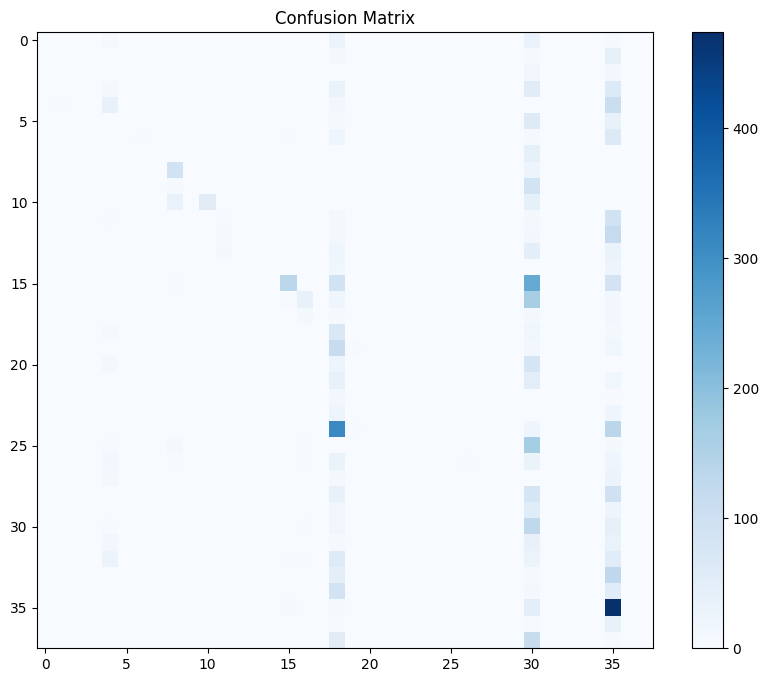

Testing configuration: image_size=32, layers=2, first_layer_filters=32


Epoch 1/50: 100%|██████████| 1358/1358 [00:07<00:00, 171.27batch/s, loss=0.707]

Epoch 1, Average Loss: 1.4235


Validation Accuracy: 19.35%
Validation Loss: 15.2405


Epoch 2/50: 100%|██████████| 1358/1358 [00:07<00:00, 173.52batch/s, loss=0.983]


Epoch 2, Average Loss: 0.7979
Validation Accuracy: 10.90%
Validation Loss: 24.3536


Epoch 3/50: 100%|██████████| 1358/1358 [00:07<00:00, 173.96batch/s, loss=0.521]

Epoch 3, Average Loss: 0.6299


Validation Accuracy: 23.97%
Validation Loss: 17.9857


Epoch 4/50: 100%|██████████| 1358/1358 [00:07<00:00, 192.05batch/s, loss=0.856]

Epoch 4, Average Loss: 0.5403


Validation Accuracy: 22.92%
Validation Loss: 23.3113


Epoch 5/50: 100%|██████████| 1358/1358 [00:07<00:00, 172.15batch/s, loss=0.478] 

Epoch 5, Average Loss: 0.4641


Validation Accuracy: 25.10%
Validation Loss: 21.4377


Epoch 6/50: 100%|██████████| 1358/1358 [00:07<00:00, 172.58batch/s, loss=0.45]  


Epoch 6, Average Loss: 0.4167
Validation Accuracy: 27.34%
Validation Loss: 24.3212
Early stopping triggered after 6 epochs.


Testing: 100%|██████████| 170/170 [00:01<00:00, 153.50batch/s, accuracy=26.9]



Test Accuracy: 26.85%
Test F1 Score (Weighted): 0.1952
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.00      0.00      0.00        70
                                 Apple___Black_rot       0.77      0.17      0.28        58
                          Apple___Cedar_apple_rust       0.00      0.00      0.00        29
                                   Apple___healthy       0.32      0.23      0.27       157
                               Blueberry___healthy       0.28      0.14      0.19       157
          Cherry_(including_sour)___Powdery_mildew       0.00      0.00      0.00       102
                 Cherry_(including_sour)___healthy       1.00      0.03      0.06        90
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00        40
                       Corn_(maize)___Common_rust_       0.77      0.81      0.79       113
               Corn_(ma

/home/alessio/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alessio/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alessio/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


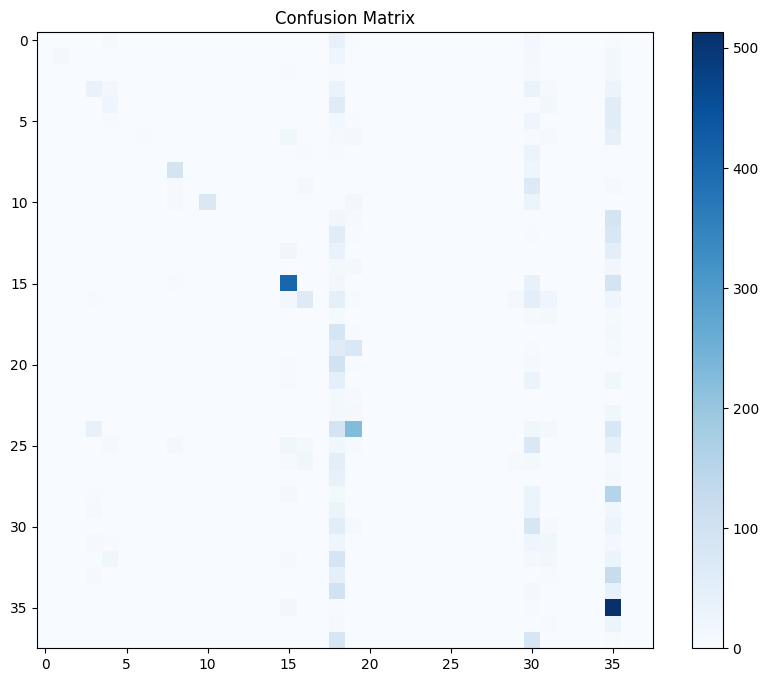

Testing configuration: image_size=32, layers=3, first_layer_filters=16


Epoch 1/50: 100%|██████████| 1358/1358 [00:07<00:00, 192.33batch/s, loss=1.67] 

Epoch 1, Average Loss: 1.9313


Validation Accuracy: 15.50%
Validation Loss: 9.1026


Epoch 2/50: 100%|██████████| 1358/1358 [00:07<00:00, 174.63batch/s, loss=1.77] 

Epoch 2, Average Loss: 1.1098


Validation Accuracy: 18.65%
Validation Loss: 10.7252


Epoch 3/50: 100%|██████████| 1358/1358 [00:07<00:00, 173.48batch/s, loss=0.515]

Epoch 3, Average Loss: 0.8922


Validation Accuracy: 17.29%
Validation Loss: 12.9444


Epoch 4/50: 100%|██████████| 1358/1358 [00:07<00:00, 177.42batch/s, loss=0.498]

Epoch 4, Average Loss: 0.7652


Validation Accuracy: 20.31%
Validation Loss: 13.4844


Epoch 5/50: 100%|██████████| 1358/1358 [00:07<00:00, 177.22batch/s, loss=0.655]

Epoch 5, Average Loss: 0.6795


Validation Accuracy: 21.17%
Validation Loss: 14.6892


Epoch 6/50: 100%|██████████| 1358/1358 [00:06<00:00, 208.15batch/s, loss=0.655]

Epoch 6, Average Loss: 0.6228


Validation Accuracy: 17.92%
Validation Loss: 16.8769
Early stopping triggered after 6 epochs.


Testing: 100%|██████████| 170/170 [00:01<00:00, 158.30batch/s, accuracy=17.5]



Test Accuracy: 17.46%
Test F1 Score (Weighted): 0.1260
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.00      0.00      0.00        70
                                 Apple___Black_rot       0.00      0.00      0.00        58
                          Apple___Cedar_apple_rust       0.00      0.00      0.00        29
                                   Apple___healthy       0.00      0.00      0.00       157
                               Blueberry___healthy       0.13      0.75      0.22       157
          Cherry_(including_sour)___Powdery_mildew       0.00      0.00      0.00       102
                 Cherry_(including_sour)___healthy       1.00      0.01      0.02        90
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00        40
                       Corn_(maize)___Common_rust_       0.57      0.12      0.19       113
               Corn_(ma

/home/alessio/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alessio/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alessio/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


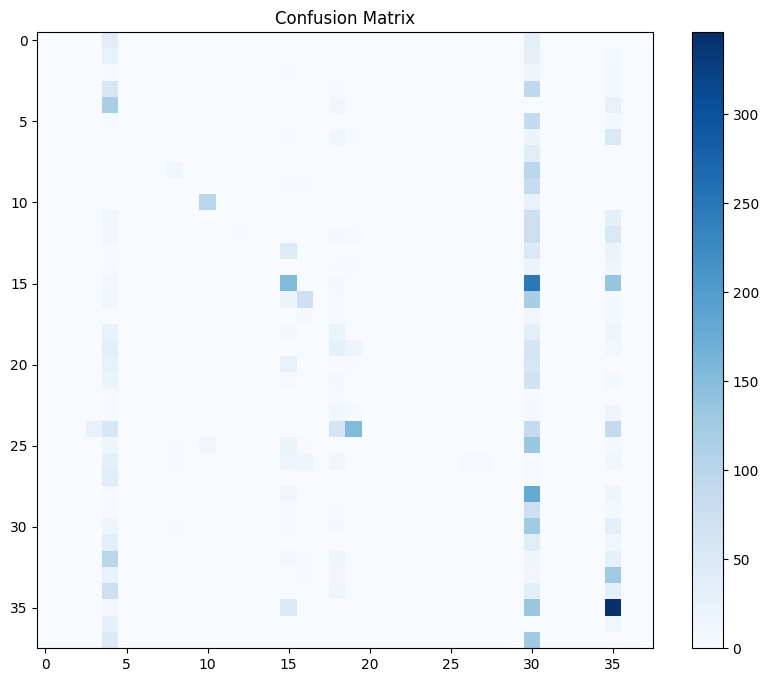

Testing configuration: image_size=32, layers=3, first_layer_filters=32


Epoch 1/50: 100%|██████████| 1358/1358 [00:08<00:00, 169.15batch/s, loss=0.475]

Epoch 1, Average Loss: 1.4959


Validation Accuracy: 14.58%
Validation Loss: 17.2489


Epoch 2/50: 100%|██████████| 1358/1358 [00:08<00:00, 168.87batch/s, loss=0.605]

Epoch 2, Average Loss: 0.7201


Validation Accuracy: 21.38%
Validation Loss: 16.4225


Epoch 3/50: 100%|██████████| 1358/1358 [00:08<00:00, 167.06batch/s, loss=0.873]

Epoch 3, Average Loss: 0.5435


Validation Accuracy: 14.80%
Validation Loss: 23.8788


Epoch 4/50: 100%|██████████| 1358/1358 [00:07<00:00, 182.53batch/s, loss=0.345] 

Epoch 4, Average Loss: 0.4465


Validation Accuracy: 10.68%
Validation Loss: 30.2984


Epoch 5/50: 100%|██████████| 1358/1358 [00:08<00:00, 169.58batch/s, loss=0.581] 

Epoch 5, Average Loss: 0.3779


Validation Accuracy: 11.67%
Validation Loss: 29.4623


Epoch 6/50: 100%|██████████| 1358/1358 [00:08<00:00, 168.96batch/s, loss=0.0721]


Epoch 6, Average Loss: 0.3281
Validation Accuracy: 10.40%
Validation Loss: 32.6285


Epoch 7/50: 100%|██████████| 1358/1358 [00:07<00:00, 176.19batch/s, loss=0.2]   

Epoch 7, Average Loss: 0.2866


Validation Accuracy: 8.36%
Validation Loss: 48.8215
Early stopping triggered after 7 epochs.


Testing: 100%|██████████| 170/170 [00:01<00:00, 149.74batch/s, accuracy=8.4] 



Test Accuracy: 8.40%
Test F1 Score (Weighted): 0.0534
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.00      0.00      0.00        70
                                 Apple___Black_rot       0.62      0.09      0.15        58
                          Apple___Cedar_apple_rust       0.00      0.00      0.00        29
                                   Apple___healthy       0.00      0.00      0.00       157
                               Blueberry___healthy       0.21      0.04      0.07       157
          Cherry_(including_sour)___Powdery_mildew       0.00      0.00      0.00       102
                 Cherry_(including_sour)___healthy       1.00      0.03      0.06        90
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00        40
                       Corn_(maize)___Common_rust_       0.92      0.39      0.55       113
               Corn_(mai

/home/alessio/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alessio/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alessio/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


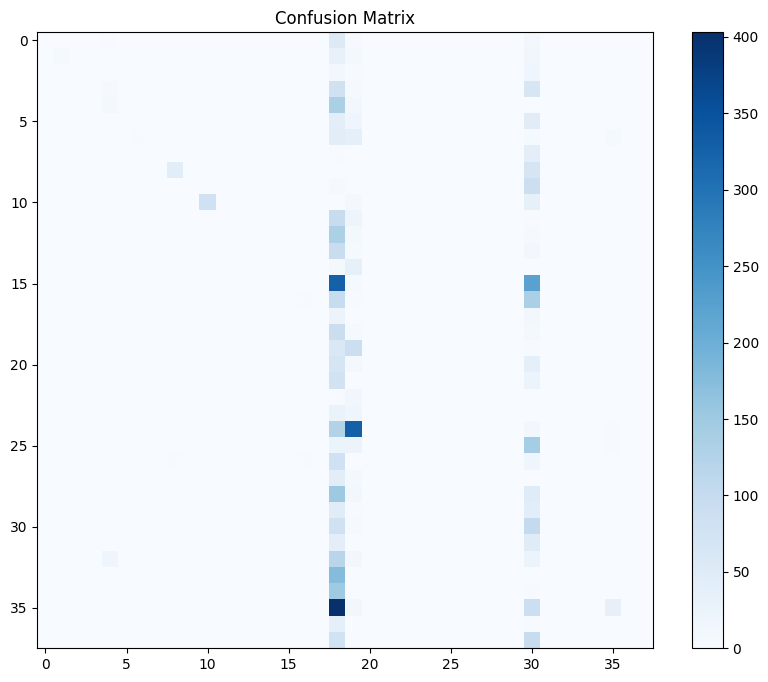

Testing configuration: image_size=256, layers=2, first_layer_filters=16


Epoch 1/50: 100%|██████████| 1358/1358 [01:19<00:00, 17.09batch/s, loss=0.62] 

Epoch 1, Average Loss: 1.2475


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1024 and 65536x512)

In [16]:
results = []  # Per salvare i risultati

for image_size, num_layers, first_layer_filters in parameter_combinations:
    print(f"Testing configuration: image_size={image_size}, layers={num_layers}, first_layer_filters={first_layer_filters}")
    
    # Prepara i dati
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ])
    train_dataset.transform = transform
    val_dataset.transform = transform
    test_dataset.transform = transform
    
    # Inizializza il modello
    model = SimpleCNN(
        num_classes=len(train_dataset.classes),
        image_width=image_size,
        num_layers=num_layers,
        first_layer_filters=first_layer_filters
    ).to(device)
    
    # Ottimizzatore e criterio
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Esegui il training
    train_model(model, criterion, optimizer, len(train_dataset.classes), train_loader)

    # Testa il modello
    test_model(model, test_loader)

    # Valuta il modello
    cm, report = evaluate_model(model, val_loader, class_names)

    # Salva i risultati
    results.append({
        "image_size": image_size,
        "num_layers": num_layers,
        "first_layer_filters": first_layer_filters,
        "confusion_matrix": cm,
        "classification_report": report
    })

#### Save results 
Puoi salvare i risultati in un file JSON o esportarli in un CSV:

In [ ]:
import json

# Salva i risultati in un file JSON
with open("results.json", "w") as f:
    json.dump(results, f, indent=4)

# Esporta solo le metriche principali in un CSV
import pandas as pd

metrics = []
for result in results:
    metrics.append({
        "image_size": result["image_size"],
        "num_layers": result["num_layers"],
        "first_layer_filters": result["first_layer_filters"],
        "accuracy": result["classification_report"]["accuracy"],
        "f1_score": result["classification_report"]["weighted avg"]["f1-score"]
    })

df = pd.DataFrame(metrics)
df.to_csv("results.csv", index=False)


#### Analyze results

Dopo aver salvato i risultati, puoi analizzare il file CSV o visualizzarli graficamente con Matplotlib/Seaborn:

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
df = pd.read_csv("results.csv")
sns.barplot(data=df, x="image_size", y="accuracy", hue="num_layers")
plt.title("Accuracy vs Image Size and Number of Layers")
plt.show()

### Heatmap sulle varie classi

Heatmap su campione di immagini per ciascuna classe

In [ ]:
import numpy as np

# Funzione per calcolare la heatmap per una singola immagine
def generate_heatmap(model, img, class_idx):
    # Calcola i gradiente rispetto alla classe specificata
    model.zero_grad()
    output = model(img)
    output[0, class_idx].backward()  # Calcola il gradiente per la classe specifica
    
    # Estrai le feature map e i gradienti
    gradients = last_conv_layer.weight.grad[0]
    weights = torch.mean(gradients, dim=(1, 2), keepdim=True)
    cam = torch.sum(weights * feature_map, dim=1, keepdim=True)
    cam = F.relu(cam)
    cam = cam.squeeze().cpu().detach().numpy()
    cam = cv2.resize(cam, (224, 224))
    cam = np.uint8(255 * cam / np.max(cam))
    
    return cam

# Lista di immagini (un campione per classe)
sample_images_per_class = [...]  # Le tue immagini per ogni classe
heatmaps_by_class = {}

for class_idx in range(num_classes):  # num_classes è il numero di classi
    heatmap_list = []
    
    for img in sample_images_per_class[class_idx]:
        heatmap = generate_heatmap(model, img, class_idx)
        heatmap_list.append(heatmap)
    
    # Media delle heatmap per la classe
    aggregated_heatmap = np.mean(heatmap_list, axis=0)
    heatmaps_by_class[class_idx] = aggregated_heatmap

# Ora `heatmaps_by_class` contiene una heatmap media per ogni classe


Heatmap aggregata per ciascuna classe

In [50]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 43.4 MB/s eta 0:00:0000:0100:01


In [30]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes, image_width, num_layers=2, first_layer_filters=16):
        super(SimpleCNN, self).__init__()

        self.num_layers = num_layers
        self.first_layer_filters = first_layer_filters

        layers = []
        in_channels = 3
        out_channels = first_layer_filters

        for i in range(num_layers):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))  # Halves spatial dimensions

            in_channels = out_channels
            out_channels *= 2  # Double the number of filters for each subsequent layer

        layers.append(nn.Dropout(0.2))

        self.features = nn.Sequential(*layers)

        # Calculate the output size after the convolutional layers
        final_width = image_width // (2 ** num_layers)
        self.classifier = nn.Sequential(
            nn.Linear(in_channels * (final_width ** 2), 512),
            nn.ReLU(),
            nn.Dropout(0.45),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

In [47]:
# Retrieve model from file 

num_classes = len(train_dataset.classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available
model = SimpleCNN(num_classes=num_classes, image_width=image_width).to(device)  # Move model to device

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.load_state_dict(torch.load('plant_disease_model.pth'))
model = model.to(device)

In [46]:
from torchvision import datasets, transforms

# Esempio di trasformazioni per immagini ridimensionate
transform_resized = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

# Trasformazione per immagini originali (non ridimensionate)
transform_original = transforms.Compose([
    transforms.ToTensor(),
])

# Carica il dataset per immagini ridimensionate
dataset_resized = datasets.ImageFolder(root='PlantVillage/val', transform=transform_resized)

# Carica il dataset per immagini originali
dataset_original = datasets.ImageFolder(root='PlantVillage/val', transform=transform_original)

# Suddividi le immagini per classe
from collections import defaultdict

sample_images_per_class_resized = defaultdict(list)
sample_images_per_class_original = defaultdict(list)

for (img_resized, label_resized), (img_original, label_original) in zip(dataset_resized, dataset_original):
    sample_images_per_class_resized[label_resized].append(img_resized)
    sample_images_per_class_original[label_original].append(img_original)

# Ora `sample_images_per_class_resized` contiene le immagini ridimensionate,
# mentre `sample_images_per_class_original` contiene le immagini originali.


In [32]:
print(model.features[0])

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [34]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
import torch.nn.functional as F

def generate_heatmap(model, img, class_idx):
    feature_map = None
    gradients = None

    # Hook per catturare la feature map
    def forward_hook(module, input, output):
        nonlocal feature_map
        feature_map = output.detach()

    # Hook per catturare i gradienti
    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0].detach()

    # Seleziona l'ultimo layer convoluzionale
    last_conv_layer = model.features[-4]  # Assumiamo che sia l'ultimo layer convoluzionale

    # Registra gli hook
    forward_handle = last_conv_layer.register_forward_hook(forward_hook)
    backward_handle = last_conv_layer.register_backward_hook(backward_hook)

    # Esegui la forward e calcola il gradiente per la classe specifica
    model.zero_grad()
    img = img.unsqueeze(0).cuda()  # Aggiungi dimensione batch e invia a GPU se necessario
    output = model(img)
    output[0, class_idx].backward()  # Calcola il gradiente rispetto alla classe

    # Rimuovi gli hook
    forward_handle.remove()
    backward_handle.remove()

    # Calcola i pesi per la Grad-CAM
    weights = torch.mean(gradients, dim=(2, 3), keepdim=True)  # Media sui gradienti spaziali
    cam = torch.sum(weights * feature_map, dim=1).squeeze()  # Somma pesata delle feature map
    cam = F.relu(cam)  # Applica ReLU per rimuovere i valori negativi

    # Normalizza e ridimensiona la heatmap
    cam = cam.cpu().numpy()
    cam = cv2.resize(cam, (img.shape[2], img.shape[3]))  # Ridimensiona alla dimensione dell'immagine originale
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)  # Normalizzazione tra 0 e 1
    cam = np.uint8(255 * cam)

    return cam

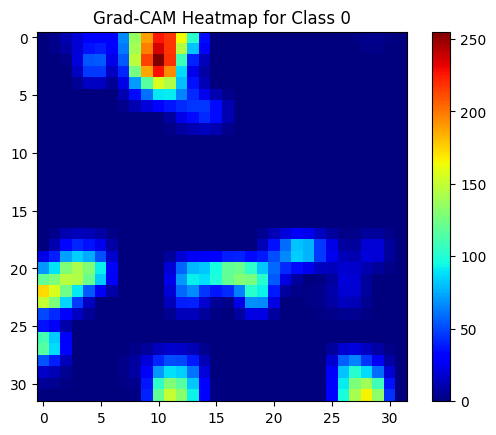

In [36]:
img = torch.randn(3, 32, 32).cuda()  # Esempio di immagine su GPU
class_idx = 0  # Indice della classe target

heatmap = generate_heatmap(model, img, class_idx)

# Visualizza la heatmap
plt.imshow(heatmap, cmap='jet')
plt.colorbar()
plt.title(f"Grad-CAM Heatmap for Class {class_idx}")
plt.show()


Generazione heatmap per la classe 0...


/tmp/ipykernel_602/3826727648.py:47: RuntimeWarning: invalid value encountered in divide
  cam = cam / np.max(cam)  # Normalizzazione tra 0 e 1
/tmp/ipykernel_602/3826727648.py:48: RuntimeWarning: invalid value encountered in cast
  cam = np.uint8(255 * cam)


Generazione heatmap per la classe 1...
Generazione heatmap per la classe 2...
Visualizzazione heatmap per la classe 0...


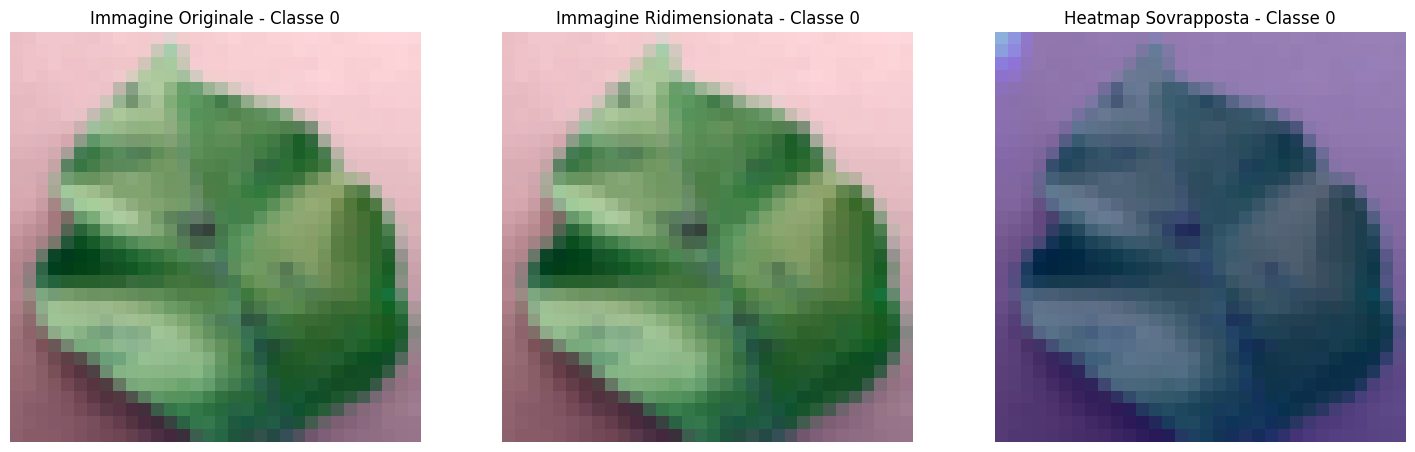

Visualizzazione heatmap per la classe 1...


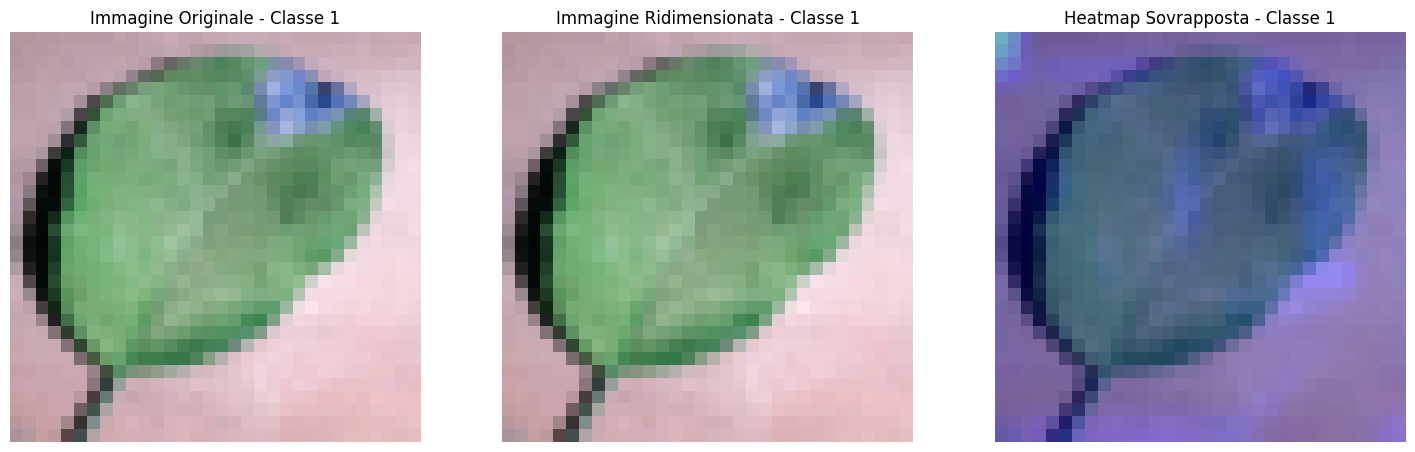

Visualizzazione heatmap per la classe 2...


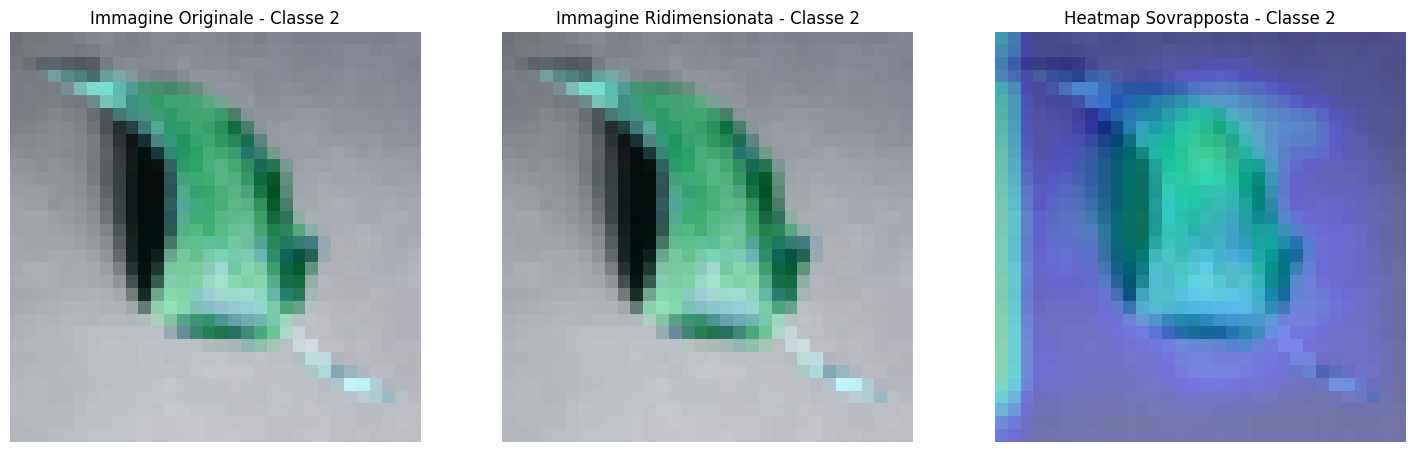

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Funzione per calcolare la heatmap aggregata per ciascuna classe
def generate_class_heatmaps(model, dataset, num_classes, num_samples_per_class):
    heatmaps_by_class = {}

    # Per ogni classe
    for class_idx in range(num_classes):
        heatmap_list = []
        print(f"Generazione heatmap per la classe {class_idx}...")

        # Campiona immagini per la classe
        class_images = [
            (img, label) for img, label in dataset if label == class_idx
        ][:num_samples_per_class]

        # Calcola la heatmap per ogni immagine
        for img, _ in class_images:
            heatmap = generate_heatmap(model, img.cuda(), class_idx)
            heatmap_list.append(heatmap)

        # Media delle heatmap per la classe
        aggregated_heatmap = np.mean(heatmap_list, axis=0)
        heatmaps_by_class[class_idx] = aggregated_heatmap

    return heatmaps_by_class

# Visualizza le heatmap aggregate per ciascuna classe
def plot_heatmaps_with_comparison(heatmaps_by_class, dataset):
    for class_idx, aggregated_heatmap in heatmaps_by_class.items():
        print(f"Visualizzazione heatmap per la classe {class_idx}...")

        # Recupera un'immagine di esempio per la classe
        sample_img = next(img for img, label in dataset if label == class_idx)
        original_img = sample_img.permute(1, 2, 0).cpu().numpy()  # Converti in formato HWC

        # Normalizza original_img a 0-255 e convertilo a uint8
        original_img_normalized = (original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255
        original_img_normalized = original_img_normalized.astype(np.uint8)

        # Ridimensiona l'immagine originale alla stessa dimensione della heatmap
        resized_img = cv2.resize(original_img_normalized, (aggregated_heatmap.shape[1], aggregated_heatmap.shape[0]))

        # Colora la heatmap
        heatmap_colored = cv2.applyColorMap(aggregated_heatmap.astype(np.uint8), cv2.COLORMAP_JET)

        # Sovrapponi immagine ridimensionata e heatmap
        superimposed_img = cv2.addWeighted(resized_img, 0.6, heatmap_colored, 0.4, 0)

        # Visualizza immagine originale, ridimensionata e heatmap sovrapposta fianco a fianco
        plt.figure(figsize=(18, 6))

        # Mostra immagine originale (non ridimensionata)
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(original_img_normalized, cv2.COLOR_BGR2RGB))  # Converti da BGR a RGB per matplotlib
        plt.title(f"Immagine Originale - Classe {class_idx}")
        plt.axis('off')

        # Mostra immagine ridimensionata
        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Immagine Ridimensionata - Classe {class_idx}")
        plt.axis('off')

        # Mostra immagine sovrapposta con heatmap
        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Heatmap Sovrapposta - Classe {class_idx}")
        plt.axis('off')

        # Mostra il grafico
        plt.show()

# Generazione heatmap per ciascuna classe
num_classes = 3  # Numero di classi nel dataset
num_samples_per_class = 10  # Numero di immagini per classe
heatmaps_by_class = generate_class_heatmaps(model, dataset, num_classes, num_samples_per_class)

# Visualizzazione heatmap aggregate
plot_heatmaps_with_comparison(heatmaps_by_class, dataset)
